In [1]:
input_size = 784
output_size = 784 
hidden1 = 256      
hidden2 = 128
hidden3 = 64
bottle = 2
weight_bit_width = 8
act_bit_width = 8

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
from torch import nn
from torch.nn import Module
import torch.nn.functional as F
from brevitas.nn import QuantLinear, QuantReLU  
import brevitas.nn as qnn
from brevitas.core.quant import QuantType

model = nn.Sequential(
            QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
            QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width  ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
            QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=weight_bit_width ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
            QuantLinear(hidden3, hidden2,bias=True, weight_bit_width=weight_bit_width ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
            QuantLinear(hidden2, hidden1,bias=True, weight_bit_width=weight_bit_width ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
            QuantLinear(hidden1, output_size,bias=True, weight_bit_width=weight_bit_width ),
            qnn.QuantIdentity(quant_type=QuantType.FP, bit_width=weight_bit_width , min_val=-1, max_val=1),
)


In [3]:
model

Sequential(
  (0): QuantLinear(
    in_features=784, out_features=256, bias=True
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(


In [4]:
import torch
from torchvision import transforms, datasets
import os, sys
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np


class my_dataset(Dataset):
    def __init__(self, img_path, data_transform = None):
        self.img_path = img_path
        self.transforms = data_transform
        self.img_list = []
        
        for file in os.listdir(self.img_path):
            img_path = os.path.join(self.img_path, file)
            self.img_list.append(img_path)
    def __getitem__(self, item):
        img = Image.open(self.img_list[item]).convert('RGB')
        img = img.resize((28,28), Image.ANTIALIAS)
        img_np = np.array(img)
        
        if self.transforms is not None:
            img = self.transforms(img_np)
        
        return img
    def __len__(self):
        return len(self.img_list)
    
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

img_path = 'bottle/train/good'
train_dataset = my_dataset(img_path, data_transform)

dataset_loader = DataLoader(train_dataset,
                           batch_size = 1,
                           shuffle = True,
                           num_workers = 1)


<ipython-input-4-08da830937fd>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((28,28), Image.ANTIALIAS)


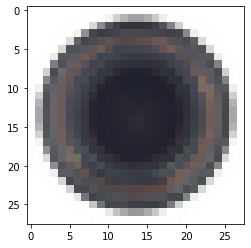

In [5]:
import matplotlib.pyplot as plt
img = train_dataset.__getitem__(0)
img = img.numpy()
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img)

In [6]:
build_dir = "/workspace/finn"

epochs = 1
batch_size = 64
lr = 0.001
# model_ae = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_function = nn.MSELoss()

#loss_function = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

<ipython-input-4-08da830937fd>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((28,28), Image.ANTIALIAS)
/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Restructured Image by AE


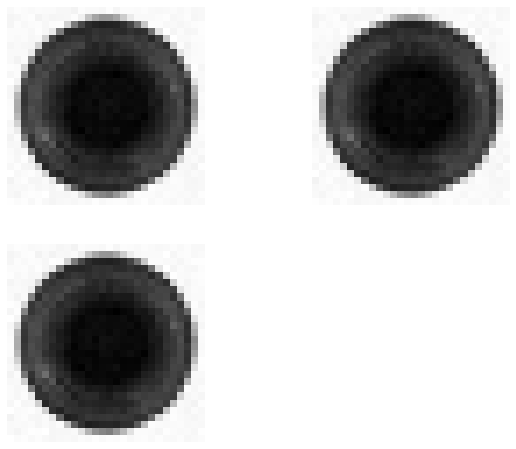

[1/1] Loss: 0.010172702372074127
[1/1] Loss: 0.010172702372074127


In [7]:
import matplotlib.pyplot as plt
# Settings
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Show images
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')

# Train
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for idx, data in enumerate(dataset_loader):
        inputs = data.view(-1, 784)
        #model_ae.zero_grad()
        model.zero_grad()
        # Forward
        #codes, decoded = model_ae(inputs)
        decoded = model(inputs)
        outputs = decoded.detach().cpu()
        loss = loss_function(decoded, inputs)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        log_loss.append(loss)
        
    print('Restructured Image by AE')
    show_images(outputs)
    plt.show()
    total_loss /= len(dataset_loader.dataset)
    scheduler.step()
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

In [8]:
torch.save(model.state_dict(), build_dir+"/autoencoder_ln.pth")

In [9]:
trained_state_dict = torch.load(build_dir+"/autoencoder_ln.pth")

model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

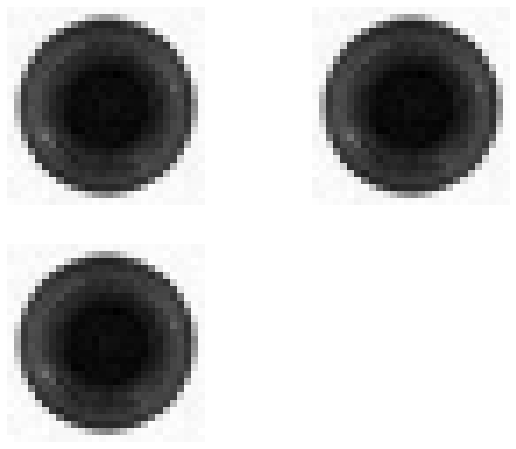

In [10]:
inputs = data.view(-1, 784)
show_images(model(inputs).detach().cpu())

In [11]:
model(inputs).detach().cpu()[0]

tensor([0.9898, 1.0066, 0.9969, 0.9920, 1.0007, 0.9921, 0.9985, 0.9840, 0.9840,
        0.9702, 0.9954, 0.9943, 0.9902, 0.9859, 0.9958, 0.9763, 0.9911, 0.9911,
        0.9917, 0.9957, 0.9947, 0.9937, 0.9911, 0.9977, 0.9911, 0.9981, 0.9845,
        0.9878, 0.9807, 0.9900, 0.9916, 1.0021, 0.9686, 0.9894, 0.9787, 0.9849,
        0.9880, 1.0036, 0.9599, 0.7998, 0.7181, 0.6525, 0.6523, 0.7025, 0.8439,
        0.9470, 0.9935, 0.9912, 0.9971, 1.0028, 1.0026, 0.9825, 0.9923, 0.9997,
        0.9825, 0.9795, 0.9812, 0.9935, 0.9863, 1.0009, 0.9988, 0.9845, 1.0057,
        1.0052, 0.8468, 0.5473, 0.3680, 0.2820, 0.2414, 0.2339, 0.2380, 0.2415,
        0.2893, 0.3595, 0.5398, 0.8222, 1.0072, 0.9980, 0.9845, 0.9901, 0.9791,
        0.9915, 1.0051, 0.9994, 1.0030, 0.9977, 1.0001, 0.9852, 1.0023, 0.9885,
        0.9374, 0.5512, 0.2710, 0.2415, 0.2500, 0.2656, 0.2924, 0.2802, 0.2898,
        0.2701, 0.2687, 0.2888, 0.2543, 0.3036, 0.5341, 0.9186, 1.0089, 0.9780,
        0.9922, 0.9827, 0.9882, 1.0007, 

In [12]:
from copy import deepcopy

modified_model = deepcopy(model)

W_orig = modified_model[0].weight.data.detach().numpy()
W_orig.shape

(256, 784)

In [13]:
from brevitas.core.quant import QuantType
from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        self.qnt_output = QuantIdentity(quant_type=QuantType.FP, bit_width=8, min_val=0, max_val=1)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        # x = (x + torch.tensor([1.0])) / 2.0  
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}     
        return out_final

model_for_export = CybSecMLPForExport(modified_model)

In [14]:
img_path = 'bottle/test/contamination'
anomaly_data = my_dataset(img_path, data_transform)
print(type(anomaly_data))
dataset_loader = DataLoader(anomaly_data,
                           batch_size = 1,
                           shuffle = True,
                           num_workers = 1)

<class '__main__.my_dataset'>


<ipython-input-4-08da830937fd>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((28,28), Image.ANTIALIAS)


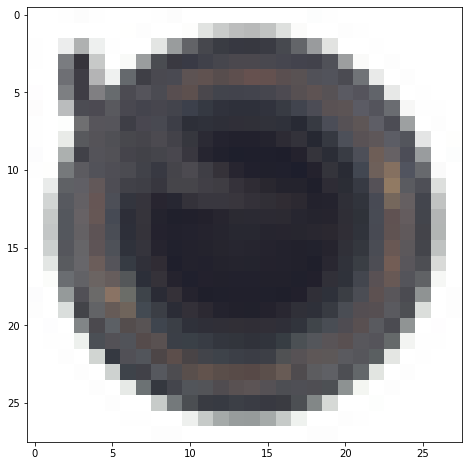

In [15]:
import matplotlib.pyplot as plt
img = anomaly_data.__getitem__(6)
img = img.numpy()
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img)

Original Images


<ipython-input-4-08da830937fd>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((28,28), Image.ANTIALIAS)


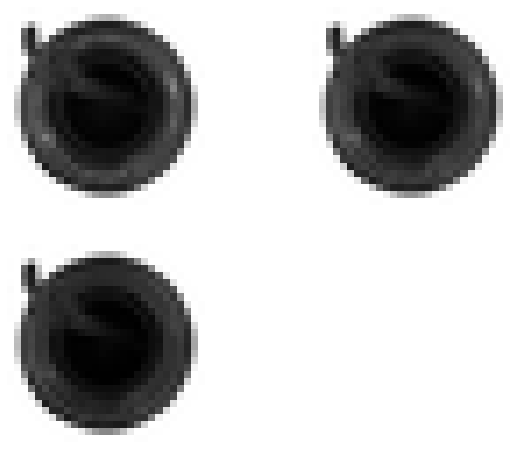

In [16]:
inputs = anomaly_data.__getitem__(6).view(-1, 28*28)
print('Original Images')
show_images(inputs)
plt.show()

In [17]:
model_for_export

CybSecMLPForExport(
  (pretrained): Sequential(
    (0): QuantLinear(
      in_features=784, out_features=256, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              (stats): _Stats(
                (stats_imp

Restructured Image by AE


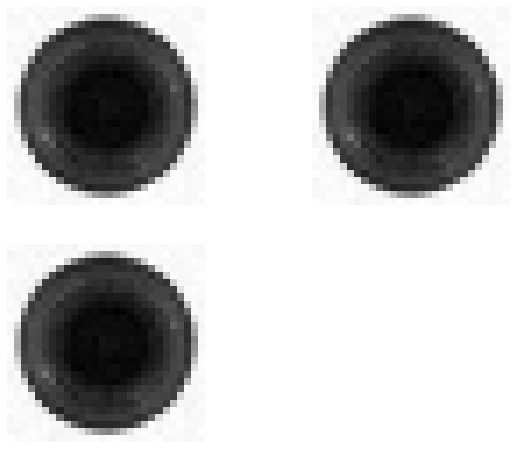

In [18]:
outputs = model_for_export(inputs)
outputs = outputs.detach().cpu()
print('Restructured Image by AE')
show_images(outputs)
plt.show()

In [19]:
import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

ready_model_filename = "autoencoder_ln.onnx"
input_shape = (1, 784)
# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)

scale = 1.0
input_t = torch.from_numpy(input_a * scale)
input_qt = QuantTensor(
    input_t, scale=torch.tensor(scale), bit_width=torch.tensor(1.0), signed=True
)

bo.export_finn_onnx(
    model_for_export, export_path=ready_model_filename, input_t=input_qt
)

print("Model saved to %s" % ready_model_filename)

AttributeError: 'NoneType' object has no attribute 'item'

In [20]:
import brevitas.onnx as bo

bo.export_finn_onnx(model, input_shape=(1,784), export_path='autoencoder_ln.onnx')

AttributeError: 'NoneType' object has no attribute 'item'

In [397]:
import onnx
from finn.util.test import get_test_model_trained

tfc = get_test_model_trained("TFC", 1, 1)
cnv = get_test_model_trained("CNV", 1, 1)

Downloading: "https://github.com/Xilinx/brevitas/releases/download/bnn_pynq-r0/cnv_1w1a-758c8fef.pth" to /tmp/home_dir/.cache/torch/hub/checkpoints/cnv_1w1a-758c8fef.pth


In [398]:
cnv

CNV(
  (conv_features): ModuleList(
    (0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clamp_min_ste): Identity()
                (restrict_value_impl): PowerOfTwoRestrictValue(
                  (float_to_int_impl): RoundSte()
                  (power_of_two): PowerOfTwo()
                )
              )
    

In [244]:
model_for_export

CybSecMLPForExport(
  (pretrained): Sequential(
    (0): QuantLinear(
      in_features=784, out_features=256, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              (stats): _Stats(
                (stats_imp